# Projeto 1 - Ciência dos Dados

Nome: Arthur Santos Pansini

Nome: Guilherme Galvão Guedes

Nome: Thiago Colobriali Gomes Godoi

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [43]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from unidecode import unidecode
import seaborn as sns
import re 
import nltk
from nltk.stem import PorterStemmer

# Baixe os recursos necessários (você só precisa fazer isso uma vez)
nltk.download('punkt')

# Inicialize o stemmer (usaremos o Porter Stemmer neste exemplo)
stemmer = PorterStemmer()

def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[´"!-.:?;$'']' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed.lower()

def stopwords(text):
    words=['a','as','o','os','ante','apos','entre','em','ate','com','para','por','perante','da','do','é','que','no','na','nas'',nos','de','deste','desta','uma','e','uns','umas','seu','sua','seus','suas', 'livro' ,'gostei', 'não', 'autor', 'autora', 'achei', 'parei', 'ler', 'esta', 'pedido', 'obra', 'volume', 'serie']
    texto_f=''
    for palavra in text.split():
        if palavra not in words:
            texto_f+=' ' + palavra
    
    return texto_f

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thiag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\thiag\OneDrive\Documentos\Insper\2023.2\CDados\Projeto1\CDadosP1


Carregando a base de dados com os tweets classificados manualmente:

In [45]:
filename = pd.read_excel('dados.xlsx')
filename.head(5)

,0
0,"Concordo com outras avaliações feitas, entre o..."
1,"Que história chata! Personagens chatos, diálog..."
2,"A estória podia ter fim no primeiro livro, des..."
3,"Muito narrativo, não prende atenção, tive apre..."
4,"Olá, Recebi uma notificação por email que não ..."


In [46]:
train = pd.read_excel('dados_treino.xlsx')
train.head(5)

,Mensagem,target,Legenda
0,Achei muito merchandising e pouco conteúdo prá...,2.0,1 = critica construtiva ao livro
1,Não é o primeiro livro da Record que oxida em ...,2.0,2 = critica construtiva a edição/pltaforma
2,"Estava com saudades de todos os personagens, m...",1.0,0 = nenhum dos dois
3,"Perdeu toda credibilidade, se realmente fosse ...",1.0,NaN
4,Ainda vou ler.,0.0,NaN


In [47]:
test = pd.read_excel('dados_teste 1.xlsx')
test.head(5) 

,Mensagem,target,Legenda
0,"Não sou de desistir de livro, mas neste não te...",1,1 = critica construtiva ao livro
1,Por ser produto não do meu interesse e recebi...,0,2 = critica construtiva a edição/plataforma
2,"Livro de agradável leitura, bastante esclarece...",0,0 = nenhum dos dois
3,No dia que era para meu livro chegar recebo um...,2,NaN
4,Como pode uma editora aproveitar o sucesso do ...,2,NaN


___
## Classificador automático


Faça aqui uma descrição do seu assunto e o que considerou como relevante ou não relevante na classificação dos tweets (Target).

Nosso projeto considera as seguintes classificações: 1 = Crítica construtiva ao livro, 2 = Crítica construtiva à edição/plataforma e 0 = Nenhum dos dois. Com isso planejamos criar um sistema de identificação de reviews novas, baseando-se em probabilidades encontradas a partir da nossa base de dados.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

### PROBABILIDADES INICIAIS: 
#### Explicamos o trabalho a partir de dois eventos para ilustra a ideia utilizada e facilitar a compreensão.

Utilizamos os seguintes conceitos inicias:
Se chamarmos a e b de eventos em nosso conjunto universo denominado $\Omega$, temos:
 
$P(a) \rightarrow$ Probabilidade do evento a ocorrer
 
$P(a^c) \rightarrow$ Probabilidade do evento a não ocorrer
 
$P(b) \rightarrow$ Probabilidade do evento b ocorrer
 
$P(b^c) \rightarrow$ Probabilidade do evento b não ocorrer
 
$P(a \cap b) \rightarrow$ Probabilidade do evento a e b ocorrer
 
$P(a|b) \rightarrow$ Probabilidade do evento a ocorrer dado que b ocorreu


Iremos começar calculando a probabilidade de palavras relevantes e irrelevantes aparecerem em nosso conjunto total:

$$ P_{relevante}= \frac{N° Palavras_{relevantes}}{N° Total_{palavras}} $$

$$ P_{irrelevante}= \frac{N° Palavras_{irrelevantes}}{N° Total_{palavras}} $$

De acordo com a teoria complementar de conjuntos:

$$ P_{relevante}+ P_{irrelevante}=1 $$

 Logo:
 
$P(I)  \ ou \ P(R^c)\rightarrow$ Probabilidade de uma frase ser irrelevante.

$P(R) \rightarrow $ Probabilidade de uma frase ser relevante.

$P(comentário) \rightarrow$ Probabilidade de determinada frase ocorrer.

As probabilidade $P(R|frase)$ ou $P(frase|R)$ , podem ser interpretadas como uma probabilidade de "peso" em um novo conjunto total. Ou seja, nos exemplos dados anteriromente temos como novos conjuntos o conjunto frase e conjunto relevância, respectivamente.

Vamos representar da seguinte forma a seguir "Qual a probabilidade de encontrarmos elementos que pertencem ao conjunto a e b no conjunto b"

$$P(a|b) = \frac{P(a \cap b)}{P(b)}$$

Ou seja:

$$P(a|b) = \frac{N° elementos(a \cap b)}{N° elementos(b)}$$

Portanto, vamos usar da mesma ideia, temos:

$$ P(R|𝑓𝑟𝑎𝑠𝑒)= \frac{P(𝑓𝑟𝑎𝑠𝑒 \cap R)}{P(𝑓𝑟𝑎𝑠𝑒)} $$
$$ P(𝑓𝑟𝑎𝑠𝑒|R)= \frac{P(𝑓𝑟𝑎𝑠𝑒 \cap R)}{P(R)} $$

$$ P(I|𝑓𝑟𝑎𝑠𝑒)= \frac{P(𝑓𝑟𝑎𝑠𝑒 \cap I)}{P(𝑓𝑟𝑎𝑠𝑒)} $$
$$ P(𝑓𝑟𝑎𝑠𝑒|I)= \frac{P(𝑓𝑟𝑎𝑠𝑒 \cap I)}{P(I)} $$


Dessa forma, encontramos a probabilidade utilizada por Naive Bayes para classificar um texto como relevante ou não relevante:

$$ P(R|𝑓𝑟𝑎𝑠𝑒)= \frac{P(𝑓𝑟𝑎𝑠𝑒|R) P(R)}{P(𝑓𝑟𝑎𝑠𝑒)} $$
$$ P(I|𝑓𝑟𝑎𝑠𝑒)= \frac{P(𝑓𝑟𝑎𝑠𝑒|I) P(I)}{P(𝑓𝑟𝑎𝑠𝑒)} $$

Essas duas probabilidades acima são utilizadas pelo classificador Naive Bayes para julgar a frase como relevante ou não.

  $\quad \Rightarrow$ Se $P(R|𝑓𝑟𝑎𝑠𝑒) > P(I|𝑓𝑟𝑎𝑠𝑒)$, o comentário será classificado como **Relevante**.

  $\quad \Rightarrow$ Se $P(R|𝑓𝑟𝑎𝑠𝑒) < P(I|𝑓𝑟𝑎𝑠𝑒)$, o comentário será classificado como **Irrelevante**.
  
Portanto, podemos dizer que as probabilidades de que o nosso classificador precisa encontrar são:
"Dada uma fase qual a probabilidade dela ser relevante?" e "Dado uma frase qual a probabilidade dela ser irrelevante?".

 $$𝑃(𝑅|𝑓𝑟𝑎𝑠𝑒)$$
 $$𝑃(𝐼|𝑓𝑟𝑎𝑠𝑒)$$
 
### Após a finalização deste projeto pretendemos construir um algoritimo que consiga tomar a decisão de agrupar uma frase como um assunto relevante ou não relevante de acordo com os três targets escolhidos sobre o tema proposto.

In [48]:
#Função de limpar o texto
train["Mensagem"] = train["Mensagem"].apply(cleanup)
train["Mensagem"] = train["Mensagem"].apply(unidecode)
train["Mensagem"] = train["Mensagem"].apply(stopwords)
words = train["Mensagem"]
stemmed_words = [stemmer.stem(word) for word in words]


test['Mensagem'] = test["Mensagem"].apply(cleanup)
test['Mensagem'] = test["Mensagem"].apply(unidecode)
test["Mensagem"] = test["Mensagem"].apply(stopwords)
words2 = test["Mensagem"]
stemmed_words2 = [stemmer.stem(word) for word in words2]


In [49]:
train_0 = train.loc[train["target"]==0,:]
train_1 = train.loc[train["target"]==1,:]
train_2 = train.loc[train["target"]==2,:]

test_0 = test.loc[test["target"]==0,:]
test_1 = test.loc[test["target"]==1,:]
test_2 = test.loc[test["target"]==2,:]

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

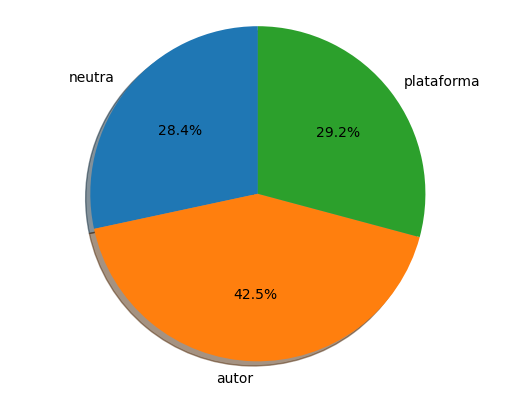

In [50]:
a = train.value_counts("target")

labels = ['neutra','autor','plataforma']

sizes = [a[0],a[1],a[2]]

fig1, ax1 = plt.subplots()

ax1.pie(sizes,labels = labels,autopct = '%1.1f%%',shadow = True, startangle = 90)

ax1.axis('equal')

plt.show()

In [51]:
palavras_0_train = ''

for n in train_0["Mensagem"]:
    palavras_0_train += ' ' + n

lista_palavras_0_train = palavras_0_train.split()
serie_palavras_0_train = pd.Series(lista_palavras_0_train)
#Tabela absoluta
tabela_absoluta_train_0 = serie_palavras_0_train.value_counts()
#Tabela rlativa
tabela_relativa_train_0 = serie_palavras_0_train.value_counts(True)

In [52]:
palavras_1_train = ''

for n in train_1["Mensagem"]:
    palavras_1_train += ' ' + n

lista_palavras_1_train = palavras_1_train.split()
serie_palavras_1_train = pd.Series(lista_palavras_1_train)
#Tabela absoluta
tabela_absoluta_train_1 = serie_palavras_1_train.value_counts()
#Tabela rlativa
tabela_relativa_train_1 = serie_palavras_1_train.value_counts(True)

In [53]:
palavras_2_train = ''

for n in train_2["Mensagem"]:
    palavras_2_train += ' ' + n

lista_palavras_2_train = palavras_2_train.split()
serie_palavras_2_train = pd.Series(lista_palavras_2_train)
#Tabela absoluta
tabela_absoluta_train_2 = serie_palavras_2_train.value_counts()
#Tabela rlativa
tabela_relativa_train_2 = serie_palavras_2_train.value_counts(True)

In [54]:
#TOTAL
lista_total_train = lista_palavras_0_train + lista_palavras_1_train + lista_palavras_2_train

#SERIE TOTAL
serie_total_train = pd.Series(lista_total_train)
#Tabela asboluta
tabela_absoluta_train_total = serie_total_train.value_counts()
#Tabela relativa
tabela_relativa_train_total = serie_total_train.value_counts(True)

In [55]:
prob_palavras_0_train = len(serie_palavras_0_train)/len(serie_total_train)
prob_palavras_1_train = len(serie_palavras_1_train)/len(serie_total_train)
prob_palavras_2_train = len(serie_palavras_2_train)/len(serie_total_train)

print(prob_palavras_0_train)
print(prob_palavras_1_train)
print(prob_palavras_2_train)

0.23218416960594682
0.4942541813630675
0.2735616490309857


# Suavização de Laplace

In [56]:
def laplace(palavra,freq_abs,serie_total):
    if palavra not in freq_abs:
        frequencia_da_palavra_categoria=1/(sum(freq_abs)+len(serie_total))
    else:
        frequencia_da_palavra_categoria=freq_abs[palavra]
    Prob_palavra_dada_cat=(1+frequencia_da_palavra_categoria)/(sum(freq_abs)+len(serie_total))
    return Prob_palavra_dada_cat

In [57]:
def naives(titulos,prob_pp_neutras,prob_pp_altas,prob_pp_baixas):
    lista_classificadora=[]
    for noticia_titulo in titulos:
        palavras=noticia_titulo.split()

        prob_neutras_noticia=1
        prob_altas_noticia=1
        prob_baixas_noticia=1

        for palavra in palavras:
            prob_neutras_noticia=prob_neutras_noticia*laplace(palavra, tabela_absoluta_train_0, serie_total_train)
            prob_altas_noticia=prob_altas_noticia*laplace(palavra, tabela_absoluta_train_1, serie_total_train)
            prob_baixas_noticia=prob_baixas_noticia*laplace(palavra, tabela_absoluta_train_2, serie_total_train)
        
        prob_neutras_noticia=prob_neutras_noticia*prob_pp_neutras
        prob_altas_noticia=prob_altas_noticia*prob_pp_altas
        prob_baixas_noticia=prob_baixas_noticia*prob_pp_baixas

        if prob_neutras_noticia>prob_altas_noticia and prob_neutras_noticia>prob_baixas_noticia:
            lista_classificadora.append(0)
        elif prob_altas_noticia>prob_neutras_noticia and prob_altas_noticia>prob_baixas_noticia:
            lista_classificadora.append(1)
        elif prob_baixas_noticia>prob_altas_noticia and prob_baixas_noticia>prob_neutras_noticia:
            lista_classificadora.append(2)
    return lista_classificadora

In [64]:
tabela_classificadora=naives(test['Mensagem'],prob_palavras_0_train,prob_palavras_1_train,prob_palavras_2_train)
series_lista_classificadora=pd.Series(tabela_classificadora)
tabela_class_rel=series_lista_classificadora.value_counts(True)
tabela_class_abs=series_lista_classificadora.value_counts()
print(tabela_classificadora)

[1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1]


In [59]:
def plot_heatmap(cross_table, fmt='g'):
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(cross_table,
                annot=True,
                fmt=fmt,
                cmap='rocket_r',
                linewidths=.5,
                ax=ax)
    plt.show();

In [60]:
tabela = pd.crosstab(test['target'], series_lista_classificadora)
tabela

col_0,0,1,2
target,,,
0,0,34,17
1,1,70,27
2,2,52,28


___
### Concluindo

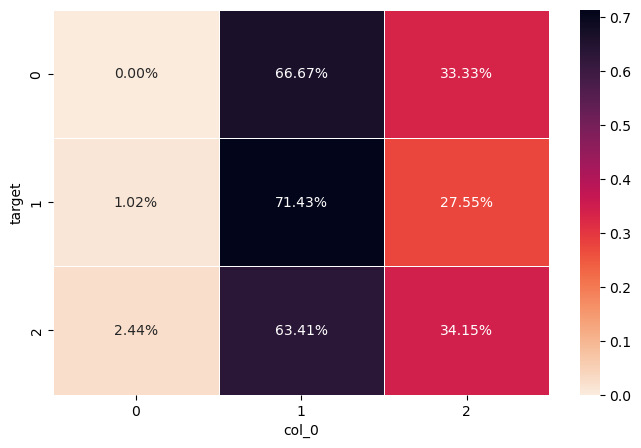

In [61]:
cross = pd.crosstab(index=test['target'],
                    columns=series_lista_classificadora,
                    normalize='index')
plot_heatmap(cross, fmt='.2%')

In [62]:
#Concatenando
total = pd.concat([train,test])

#Limpando os frases
total['Mensagem'] = total['Mensagem'].apply(cleanup)
total['Mensagem'] = total['Mensagem'].apply(stopwords)
total.target

0      2.0
1      2.0
2      1.0
3      1.0
4      0.0
      ... 
245    0.0
246    2.0
247    0.0
248    0.0
249    0.0
Name: target, Length: 995, dtype: float64

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [63]:
p_true = tabela.loc[0, 0]
p_false = tabela.loc[0, 1] + tabela.loc[0, 2]
print(f'''
Porcentagem de neutros verdadeiros: {p_true/(p_true+p_false)*100: .2f}%.
Porcentagem de falsos neutros: {p_false/(p_true+p_false)*100: .2f}%.
''')


neg_true = tabela.loc[1, 1]
neg_false = tabela.loc[1, 0] + tabela.loc[1, 2]
print(f'''
Porcentagem de comentarios sobre o autor verdadeiros: {neg_true/(neg_true+neg_false)*100: .2f}%.
Porcentagem de falsos comentarios sobre o autor: {neg_false/(neg_true+neg_false)*100: .2f}%.
''')


ntr_true = tabela.loc[2, 2]
ntr_false = tabela.loc[2, 0] + tabela.loc[2, 1]
print(f'''
Porcentagem de comentarios sobre a plataforma/edição verdadeiros: {ntr_true/(ntr_true+ntr_false)*100: .2f}%.
Porcentagem de falsos comentarios sobre a plataforma/edição: {ntr_false/(ntr_true+ntr_false)*100: .2f}%.
''')


acurace = (p_true + neg_true + ntr_true)/(p_false + neg_false + ntr_false + p_true + neg_true + ntr_true)
print(f'''
Acurácia do Classificador (Porcentagem de positivos/ Total): {acurace*100: .2f}%.
''')


Porcentagem de neutros verdadeiros:  0.00%.
Porcentagem de falsos neutros:  100.00%.


Porcentagem de comentarios sobre o autor verdadeiros:  71.43%.
Porcentagem de falsos comentarios sobre o autor:  28.57%.


Porcentagem de comentarios sobre a plataforma/edição verdadeiros:  34.15%.
Porcentagem de falsos comentarios sobre a plataforma/edição:  65.85%.


Acurácia do Classificador (Porcentagem de positivos/ Total):  42.42%.



___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**